In [1]:
!pip install -q langgraph langsmith langchain langchain_groq langchain_community langchain-core langchainhub langgraph-supervisor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 8.9 MB/s eta 0:00:00


## Get API Key

In [2]:
import os
import getpass
if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")


Enter your Groq API key: ··········


## LLM Defined

In [34]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    groq_api_key = os.environ['GROQ_API_KEY'],
    model = 'gemma2-9b-it',
    temperature = 0.2

)
print(llm)

client=<groq.resources.chat.completions.Completions object at 0x7c6f57d14f90> async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7c6f57d35a90> model_name='gemma2-9b-it' temperature=0.2 model_kwargs={} groq_api_key=SecretStr('**********')


## State

In [35]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

## Custom tools

In [36]:
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor

from langchain.tools import Tool

In [37]:
## define tool function

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

mul_tool = Tool.from_function(
    name = 'Multiply',
    func = multiply,
    description = 'Multiplication of Two numbers'
)



def add(a: int, b: int) -> int:
    """
    Add a and b

    Args:
    a: First int
    b: Second Integer
    """
    return a+b

add_tool = Tool.from_function(
    name = 'Add',
    func = add,
    description = 'Addition of Two numbers'

)


def divide(a: int, b: int) -> float:
    """
    Divide a and b

    Args:
    a: First int
    b: Second Integer
    """
    return a/b

div_tool = Tool.from_function(
    name = 'Divide',
    func = divide,
    description = 'Division of Two numbers'

)

In [38]:
tool_list = [mul_tool, add_tool, div_tool]


llm_with_tools = llm.bind_tools(tools=tool_list)

print(llm_with_tools)

bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7c6f57d14f90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7c6f57d35a90>, model_name='gemma2-9b-it', temperature=0.2, model_kwargs={}, groq_api_key=SecretStr('**********')) kwargs={'tools': [{'type': 'function', 'function': {'name': 'Multiply', 'description': 'Multiplication of Two numbers', 'parameters': {'properties': {'__arg1': {'title': '__arg1', 'type': 'string'}}, 'required': ['__arg1'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'Add', 'description': 'Addition of Two numbers', 'parameters': {'properties': {'__arg1': {'title': '__arg1', 'type': 'string'}}, 'required': ['__arg1'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'Divide', 'description': 'Division of Two numbers', 'parameters': {'properties': {'__arg1': {'title': '__arg1', 'type': 'string'}}, 'required': ['__arg1'], 'type': 'object'}}}]} config={} config_factories=[]


In [39]:
## defining Chat Bot Node and Tool Node
from langgraph.prebuilt import ToolNode, tools_condition

def chat_bot(state: State)-> State:
    response = { 'messages' : llm_with_tools.invoke(state['messages'])}
    return response

tool_node = ToolNode(tools = tool_list)

In [40]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)

# Define nodes
builder.add_node('Chat Bot', chat_bot)
builder.add_node('tools', tool_node)

## defining edges to connect
builder.add_edge(START, 'Chat Bot')
builder.add_conditional_edges('Chat Bot', tools_condition)
builder.add_edge('tools', 'Chat Bot')
builder.add_edge('Chat Bot', END)


graph = builder.compile()

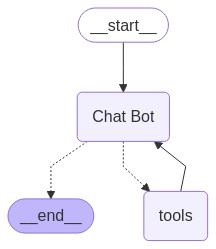

In [41]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [44]:
from langchain_core.messages import HumanMessage


while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    user_msg = {"messages": [HumanMessage(content=user_input)]}

    # Pass the user message to the graph
    for event in graph.stream(user_msg):
        for value in event.values():
            # Extract assistant response from AIMessage
            if hasattr(value['messages'], 'content'):
                print("Assistant:", value['messages'].content)


User: add 5 and 5
Assistant: 
Assistant: 
Assistant: 
Assistant: 
Assistant: 
Assistant: 
Assistant: 
Assistant: 
Assistant: 10 

User: q
Goodbye!


# Using Supervisor LangGraph Library

In [1]:
!pip install -q langgraph langsmith langchain langchain_groq langchain_community arxiv wikipedia langgraph-supervisor langchain_openai

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.7/437.7 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194

In [2]:
import os
import getpass
if "OPEN_AI_KEY" not in os.environ:
    os.environ["OPEN_AI_KEY"] = getpass.getpass("Enter your Open API key: ")


Enter your Open API key: ··········


In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    api_key = os.environ['OPEN_AI_KEY'],

    model = 'gpt-4o-mini',
    temperature = 0.2

)
print(llm.invoke('Hii'))

content='Hello! How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BW1no0X6qBfNFvkL80DQTXKy7kTxD', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--1d9cf47e-1c1b-4b08-afcf-b82317413cb6-0' usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


In [4]:
from langchain.tools import StructuredTool

## define tool function

def multiply(a: int, b: int) -> int:
    """Multiply a and b.


    Args:
        a: first int
        b: second int
    """
    return a * b

mul_tool = StructuredTool.from_function(
    name = 'Multiply',
    func = multiply,
    description = 'Multiplication of Two numbers'
)



def add(a: int, b: int) -> int:
    """
    Add a and b

    Args:
    a: First int
    b: Second Integer
    """
    return a+b

add_tool = StructuredTool.from_function(
    name = 'Add',
    func = add,
    description = 'Addition of Two numbers'

)


def divide(a: int, b: int) -> float:
    """
    Divide a and b

    Args:
    a: First int
    b: Second Integer
    """
    return a/b

div_tool = StructuredTool.from_function(
    name = 'Divide',
    func = divide,
    description = 'Division of Two numbers'

)

In [5]:
## Getting tools for our Agent to acces
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

## Getting one document at a time and inside that document max 300 charcters


arxiv_wrapper = ArxivAPIWrapper(top_k_results = 5,
                                doc_content_chars_max = 3000
                                )

arxiv_tool = ArxivQueryRun(api_wrapper = arxiv_wrapper)




wiki_wrapper = WikipediaAPIWrapper(top_k_results = 5,
                                doc_content_chars_max = 3000
                                  )
wiki_tool = WikipediaQueryRun(api_wrapper = wiki_wrapper)

In [6]:
tool_math = [mul_tool, add_tool, div_tool]

tool_web = [arxiv_tool, wiki_tool]


In [7]:
from langgraph.prebuilt import create_react_agent

Mathematics_Agent = create_react_agent(
    model=llm,
    tools=tool_math,
    name = 'MathAgent',
    prompt = ( "You are the best mathematics agent"
              "After you're done with your tasks, respond to the supervisor directly"
              "Responds only with the results")

)

Web_Agent = create_react_agent(
    model=llm,
    tools=tool_web,
    name = 'ResearchAgent',
    prompt = ( "You are the best web Search agent"
              "After you're done with your tasks, respond to the supervisor directly"
              "Responds only with the results"
              )

)


## pretty print helper function

In [8]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [9]:
for chunk in Mathematics_Agent.stream(
    {"messages": [{"role":"user","content":"Add 3 and 4"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: MathAgent
Tool Calls:
  Add (call_L0BaAQIfKsuV1kWZe0931wTO)
 Call ID: call_L0BaAQIfKsuV1kWZe0931wTO
  Args:
    a: 3
    b: 4


Update from node tools:


================================= Tool Message =================================
Name: Add

7


Update from node agent:


================================== Ai Message ==================================
Name: MathAgent

7




In [10]:
for chunk in Web_Agent.stream(
    {"messages": [{"role": "user","content":"Who is Narendra Modi"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: ResearchAgent
Tool Calls:
  wikipedia (call_k8LzrPRUpXX5obpm6MSv64Ob)
 Call ID: call_k8LzrPRUpXX5obpm6MSv64Ob
  Args:
    query: Narendra Modi


Update from node tools:


================================= Tool Message =================================
Name: wikipedia

Page: Narendra Modi
Summary: Narendra Damodardas Modi (born 17 September 1950) is an Indian politician who has served as the  prime minister of India since 2014. Modi was the chief minister of Gujarat from 2001 to 2014 and is the member of parliament (MP) for Varanasi. He is a member of the Bharatiya Janata Party (BJP) and of the Rashtriya Swayamsevak Sangh (RSS), a right-wing Hindu nationalist paramilitary volunteer organisation. He is the longest-serving prime minister outside the Indian National Congress.
Modi was born and raised in Vadnagar, Gujarat, where he completed his secondary education. He was introd

In [11]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model = llm,
    agents= [Mathematics_Agent, Web_Agent],
    prompt = (
                "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages= True,
    output_mode= 'full_history',
    supervisor_name = 'supervisor',
)


In [12]:
app = supervisor.compile()

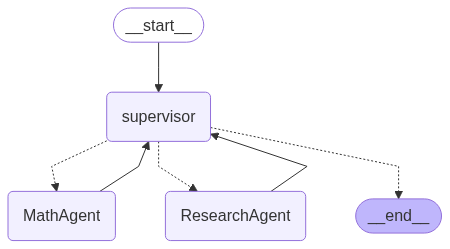

In [13]:
from IPython.display import display, Image


display(Image(app.get_graph().draw_mermaid_png()))

In [14]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["exit", "quit", "q"]:
        print("Goodbye!")
        break

    result = app.invoke({"messages": [{"role":"user","content": user_input}]})

    for m in result['messages']:
        m.pretty_print()

    print('\n\n')

User: do you know what is operation sindoor?
================================ Human Message =================================

do you know what is operation sindoor?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_researchagent (call_QRfXSYMe1tYgsnyfTCzkt1h0)
 Call ID: call_QRfXSYMe1tYgsnyfTCzkt1h0
  Args:
================================= Tool Message =================================
Name: transfer_to_researchagent

Successfully transferred to ResearchAgent
================================== Ai Message ==================================
Name: ResearchAgent
Tool Calls:
  wikipedia (call_IIqupwpbn0415MEHPLjG0Vjm)
 Call ID: call_IIqupwpbn0415MEHPLjG0Vjm
  Args:
    query: Operation Sindoor
================================= Tool Message =================================
Name: wikipedia

Page: Sindoor
Summary: Sindoor (Hindi: सिंदूर, IAST: sindūr) or sindura (Sanskrit: सिन्दूर,IAST: sindūra) is a traditional vermi